In [104]:
import pandas as pd
import numpy as np
import seaborn as sns

PATH_READ = '301085_test_raw.csv'
PATH_WRITE = '301085_test_withF.csv'
# df = pd.read_csv(PATH_READ, index_col='Timestamp')
df = pd.read_csv(PATH_READ)


Preprocessing, cleaning unwanted cols

In [105]:
df = df.drop(['InstrumentID','TradingDay','PreClosePrice',], axis=1)
# df.index = pd.to_datetime(df.index)

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close'], dtype='object')


Add hist return features

In [106]:
def hist_ret_close(df, param):
    return df['Close'] / df['Close'].shift(param)

df.insert(loc=df.columns.get_loc('Close')+1, column= 'STOCK_Hist_Ret_Close_15min', value= hist_ret_close(df,15))
df.insert(loc=df.columns.get_loc('Close')+1, column= 'STOCK_Hist_Ret_Close_10min', value= hist_ret_close(df,10))
df.insert(loc=df.columns.get_loc('Close')+1, column= 'STOCK_Hist_Ret_Close_5min', value= hist_ret_close(df,5))
df.insert(loc=df.columns.get_loc('Close')+1, column= 'STOCK_Hist_Ret_Close_3min', value= hist_ret_close(df,3))

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'STOCK_Hist_Ret_Close_3min', 'STOCK_Hist_Ret_Close_5min',
       'STOCK_Hist_Ret_Close_10min', 'STOCK_Hist_Ret_Close_15min'],
      dtype='object')


Add log return features

In [107]:
df['STOCK_Log_Return_Close_1min'] = np.log(df['Close'] / df['Close'].shift(1))

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'STOCK_Hist_Ret_Close_3min', 'STOCK_Hist_Ret_Close_5min',
       'STOCK_Hist_Ret_Close_10min', 'STOCK_Hist_Ret_Close_15min',
       'STOCK_Log_Return_Close_1min'],
      dtype='object')


Add average price and mean price from 4

In [108]:
df['Avg'] = df['Turnover']/df['Volume']

# For unchanged prices, fill zero

# 目前对于涨/跌停这种情况的策略是在数据里补0，也许可以用NaN然后删除？
# df['AvgPrice'].fillna(0, inplace=True)


nan_rows_Avg = df[df['Avg'].isnull()]

# 如遇涨/跌停，直接用高开低收的价格，因为都一样
for index, row in nan_rows_Avg.iterrows():
    if row['High'] == row['Low'] == row['Open'] == row['Close']:
        row['Avg'] = row['High']

df.update(nan_rows_Avg)

print(df)

df['4meanPrice'] = (df['High']+df['Low']+df['Close']+df['Open'])/4.0


                Timestamp   Open   High    Low    Volume    Turnover  Close  \
0     2023-07-07 09:26:00  69.40  69.40  69.40   18500.0   1283900.0  69.40   
1     2023-07-07 09:31:00  69.31  69.31  68.40   68900.0   4757542.0  68.40   
2     2023-07-07 09:32:00  68.40  68.50  68.05   63800.0   4353188.0  68.05   
3     2023-07-07 09:33:00  68.01  68.01  67.50  147600.0   9992348.0  67.55   
4     2023-07-07 09:34:00  67.75  67.75  67.30  179500.0  12119316.0  67.30   
...                   ...    ...    ...    ...       ...         ...    ...   
2427  2023-07-20 14:58:00  63.33  63.34  63.33    1900.0    120294.0  63.34   
2428  2023-07-20 14:59:00  63.34  63.34  63.34       0.0         0.0  63.34   
2429  2023-07-20 15:00:00  63.34  63.34  63.34       0.0         0.0  63.34   
2430  2023-07-20 15:01:00  63.37  63.37  63.37   46500.0   2946705.0  63.37   
2431  2023-07-20 15:35:00  63.37  63.37  63.37       0.0         0.0  63.37   

      STOCK_Hist_Ret_Close_3min  STOCK_Hist_Ret_Clo

Add log return based on Avg

In [109]:
df['STOCK_Log_Return_Avg_1min'] = np.log(df['Avg'] / df['Avg'].shift(1))

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'STOCK_Hist_Ret_Close_3min', 'STOCK_Hist_Ret_Close_5min',
       'STOCK_Hist_Ret_Close_10min', 'STOCK_Hist_Ret_Close_15min',
       'STOCK_Log_Return_Close_1min', 'Avg', '4meanPrice',
       'STOCK_Log_Return_Avg_1min'],
      dtype='object')


Hist based on avg price

In [110]:
def hist_ret_avg(df, param):
    return df['Avg'] / df['Avg'].shift(param)

df['STOCK_Hist_Ret_Avg_3min'] = hist_ret_avg(df, 3)
df['STOCK_Hist_Ret_Avg_5min'] = hist_ret_avg(df, 5)
df['STOCK_Hist_Ret_Avg_10min'] = hist_ret_avg(df, 10)
df['STOCK_Hist_Ret_Avg_15min'] = hist_ret_avg(df, 15)

Experiment with rolling volatility

In [111]:
def rolling_std(df, window_size):
    return df['Close'].rolling(window=window_size).std()

df['STOCK_Vol_5min_Close'] = rolling_std(df, 5)
df['STOCK_Vol_10min_Close'] = rolling_std(df, 10)
df['STOCK_Vol_15min_Close'] = rolling_std(df, 15)

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'STOCK_Hist_Ret_Close_3min', 'STOCK_Hist_Ret_Close_5min',
       'STOCK_Hist_Ret_Close_10min', 'STOCK_Hist_Ret_Close_15min',
       'STOCK_Log_Return_Close_1min', 'Avg', '4meanPrice',
       'STOCK_Log_Return_Avg_1min', 'STOCK_Hist_Ret_Avg_3min',
       'STOCK_Hist_Ret_Avg_5min', 'STOCK_Hist_Ret_Avg_10min',
       'STOCK_Hist_Ret_Avg_15min', 'STOCK_Vol_5min_Close',
       'STOCK_Vol_10min_Close', 'STOCK_Vol_15min_Close'],
      dtype='object')


In [112]:
df['STOCK_BOP'] = ((df['Close']-df['Open']) / (df['High']-df['Low']))

print(df['STOCK_BOP'])

0            NaN
1      -1.000000
2      -0.777778
3      -0.901961
4      -1.000000
          ...   
2427    1.000000
2428         NaN
2429         NaN
2430         NaN
2431         NaN
Name: STOCK_BOP, Length: 2432, dtype: float64


Average True Range

In [113]:
df['High-Low'] = df['High'] - df['Low']
df['High-Close_prev'] = abs(df['High'] - df['Close'].shift(1))
df['Low-Close_prev'] = abs(df['Low'] - df['Close'].shift(1))
df['STOCK_TR'] = df[['High-Low', 'High-Close_prev', 'Low-Close_prev']].max(axis=1)

# Choose the ATR period
ATR_period = 16

# Calculate Average True Range (ATR)
df['STOCK_ATR_16'] = df['STOCK_TR'].rolling(ATR_period).mean()

# Drop the intermediate columns used for TR calculation
df.drop(['High-Low', 'High-Close_prev', 'Low-Close_prev'], axis=1, inplace=True)

Add Triple Barrier Target

<Axes: >

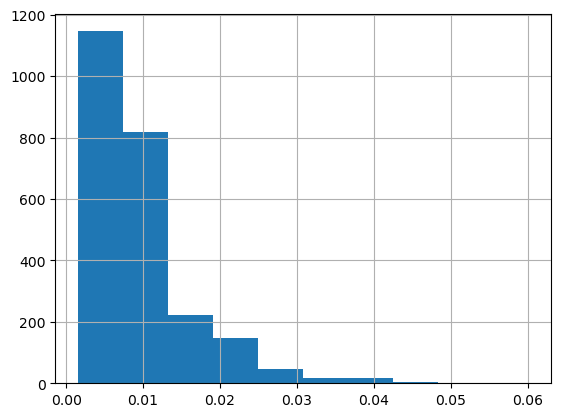

In [114]:
df['15min_range'] = df['High'].rolling(15).max() - df['Low'].rolling(15).min()
(df['15min_range'] /df['High']).hist()

In [115]:
def getDailyVol(data, span=30):
    df = data.assign(Return = lambda x: data['Close'] / data['Close'].shift(1)-1)
    sigma = df['Return'].ewm(span=span).std()
    return sigma

vol = getDailyVol(data=df)

In [116]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

events = df[['Timestamp']].copy(deep=True)
events['VB'] = df['Timestamp'] + pd.Timedelta(minutes=15)
events['Vol'] = vol

print(events)

               Timestamp                  VB       Vol
0    2023-07-07 09:26:00 2023-07-07 09:41:00       NaN
1    2023-07-07 09:31:00 2023-07-07 09:46:00       NaN
2    2023-07-07 09:32:00 2023-07-07 09:47:00  0.006571
3    2023-07-07 09:33:00 2023-07-07 09:48:00  0.004757
4    2023-07-07 09:34:00 2023-07-07 09:49:00  0.004639
...                  ...                 ...       ...
2427 2023-07-20 14:58:00 2023-07-20 15:13:00  0.001431
2428 2023-07-20 14:59:00 2023-07-20 15:14:00  0.001386
2429 2023-07-20 15:00:00 2023-07-20 15:15:00  0.001341
2430 2023-07-20 15:01:00 2023-07-20 15:16:00  0.001299
2431 2023-07-20 15:35:00 2023-07-20 15:50:00  0.001258

[2432 rows x 3 columns]


In [117]:
def TBL(df, events, width):
    
    res = events[['Timestamp', 'VB']].copy(deep=True)
    
    if width[0] > 0: events['UB'] = width[0]*events['Vol']
    else: events['UB'] = np.nan
        
    if width[1] > 0: events['DB'] = -width[1]*events['Vol']
    else: events['DB'] = np.nan
        
    for col,date,vb in res.itertuples():
        df0 = df[(df['Timestamp'] > date) & (df['Timestamp'] < vb)].copy(deep=True)
        df0['Return'] = df0['Close'] / df.loc[df['Timestamp'] == date, 'Close'].iloc[0]-1
        
        idx = (res['Timestamp'] == date)
        
        res.loc[idx, 'ut'] = df0.loc[df0['Return'] > events.loc[idx,'UB'].iloc[0], 'Timestamp'].min()
        res.loc[idx, 'dt'] = df0.loc[df0['Return'] < events.loc[idx,'DB'].iloc[0], 'Timestamp'].min()
            
    return res

In [118]:
def get_first_touch(df, events, width):
    res = TBL(df, events, width)
    res['First'] = res[['VB', 'ut', 'dt']].dropna(how='all').min(axis=1)
    return res

# 上下栅栏的宽度由 vol(span) * 系数[up,down] 决定
result = get_first_touch(df,events,width = [0.4,0.4])
print(result)

               Timestamp                  VB  ut                  dt  \
0    2023-07-07 09:26:00 2023-07-07 09:41:00 NaT                 NaT   
1    2023-07-07 09:31:00 2023-07-07 09:46:00 NaT                 NaT   
2    2023-07-07 09:32:00 2023-07-07 09:47:00 NaT 2023-07-07 09:33:00   
3    2023-07-07 09:33:00 2023-07-07 09:48:00 NaT 2023-07-07 09:34:00   
4    2023-07-07 09:34:00 2023-07-07 09:49:00 NaT 2023-07-07 09:35:00   
...                  ...                 ...  ..                 ...   
2427 2023-07-20 14:58:00 2023-07-20 15:13:00 NaT                 NaT   
2428 2023-07-20 14:59:00 2023-07-20 15:14:00 NaT                 NaT   
2429 2023-07-20 15:00:00 2023-07-20 15:15:00 NaT                 NaT   
2430 2023-07-20 15:01:00 2023-07-20 15:16:00 NaT                 NaT   
2431 2023-07-20 15:35:00 2023-07-20 15:50:00 NaT                 NaT   

                   First  
0    2023-07-07 09:41:00  
1    2023-07-07 09:46:00  
2    2023-07-07 09:33:00  
3    2023-07-07 09:34:00  


In [119]:
def get_label(df,result):
    result = result.dropna(subset=['First'])
    outcome = result[['Timestamp']].copy(deep=True)
    
    price_t0 = pd.merge(result,df,on=['Timestamp'],how='left')['Close']
    price_t1 = pd.merge(result,df,left_on=['First'], right_on=['Timestamp'], how = 'left')['Close']
    
    outcome['Return'] = price_t1/price_t0-1
    outcome['TB_15min_Label'] = np.sign(outcome['Return'].dropna())
    
    outcome = outcome.drop(['Return'], axis = 1)

    return outcome

outcome = get_label(df,result)
print(outcome)

df = pd.merge(df,outcome, on=['Timestamp'],how='inner')

               Timestamp  TB_15min_Label
0    2023-07-07 09:26:00            -1.0
1    2023-07-07 09:31:00            -1.0
2    2023-07-07 09:32:00            -1.0
3    2023-07-07 09:33:00            -1.0
4    2023-07-07 09:34:00            -1.0
...                  ...             ...
2427 2023-07-20 14:58:00             NaN
2428 2023-07-20 14:59:00             NaN
2429 2023-07-20 15:00:00             NaN
2430 2023-07-20 15:01:00             NaN
2431 2023-07-20 15:35:00             NaN

[2432 rows x 2 columns]


Cleaning NaN and unwanted data

In [120]:
# print('Number of rows before cleaning: %d'%df.shape[0])

df.index = df['Timestamp']
df = df.drop(['Timestamp'], axis=1)

# df = df[(df['Target_Close_1min'] != 0)
#                       & (df['Target_Close_5min_Mean'] != 0)
#                       & (df['Target_Close_10min_Mean'] != 0)
#                       & (df['Target_Close_15min_Mean'] != 0)
#                      ]
# pd.set_option ('mode.use_inf_as_na', True)
# df = df.dropna()


# print('Number of rows after cleaning: %d'%df.shape[0])

# print(df)

Saving CSV

In [121]:
df.to_csv(PATH_WRITE)